In [1]:
import numpy as np
import pandas as pd

from mrashpen.inference.penalized_regression import PenalizedRegression as PLR
from mrashpen.inference.mrash_wrapR          import MrASHR
from mrashpen.models.plr_ash                 import PenalizedMrASH
from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled
from mrashpen.inference.ebfit                import ebfit
from mrashpen.inference                      import lbfgsfit
from mrashpen.utils                          import R_lasso
from mrashpen.inference                      import elbo as elbo_py
from mrashpen.inference                      import coordinate_descent_step as cd_step
from mrashpen.models                         import mixture_gaussian as mix_gauss

import sys
sys.path.append('/home/saikat/Documents/work/sparse-regression/simulation/eb-linreg-dsc/dsc/functions')
import simulate

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')


def center_and_scale(Z):
    dim = Z.ndim
    if dim == 1:
        Znew = Z / np.std(Z)
        Znew = Znew - np.mean(Znew)
    elif dim == 2:
        Znew = Z / np.std(Z, axis = 0)
        Znew = Znew - np.mean(Znew, axis = 0).reshape(1, -1)
    return Znew

def initialize_ash_prior(k, scale = 2, sparsity = None):
    w = np.zeros(k)
    w[0] = 1 / k if sparsity is None else sparsity
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

def plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, bhat, 
                         intercept = 0, title = None):
    ypred = np.dot(Xtest, bhat) + intercept
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(ytest, ypred, s = 2, alpha = 0.5)
    mpl_utils.plot_diag(ax1)
    ax2.scatter(btrue, bhat)
    mpl_utils.plot_diag(ax2)

    ax1.set_xlabel("Y_test")
    ax1.set_ylabel("Y_predicted")
    ax2.set_xlabel("True b")
    ax2.set_ylabel("Predicted b")
    if title is not None:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()
    
    
def plot_convergence(objs, methods, nwarm, eps = 1e-8):
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(111)

    objmin  = np.min([np.min(x) for x in objs])

    for obj, method, iteq in zip(objs, methods, nwarm):
        m_obj = np.array(obj)[iteq:] - objmin
        m_obj = m_obj[m_obj > 0]
        ax1.plot(range(iteq, len(m_obj) + iteq), np.log10(m_obj), label = method, 
                 marker = 'o', markersize = 1)
    ax1.legend()

    ax1.set_xlabel("Number of Iterations")
    ax1.set_ylabel("log( max(ELBO) - ELBO )")

    plt.show()
    return

def plot_trendfilter_mrashpen(X, y, beta, ytest, bhat,
                              intercept = 0, title = None):
    n = y.shape[0]
    p = X.shape[1]

    ypred = np.dot(X, bhat) + intercept
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(np.arange(n), ytest, edgecolor = 'black', facecolor='white')
    ax1.plot(np.arange(n), ypred)
    ax1.set_xlabel("Sample index")
    ax1.set_ylabel("Y")

    ax2.scatter(np.arange(p), beta, edgecolor = 'black', facecolor = 'white')
    ax2.scatter(np.arange(p), bhat, s = 40, color = 'firebrick')
    ax2.set_xlabel("Sample index")
    ax2.set_ylabel("b")
    
    if title is not None:
        fig.suptitle(title)

    plt.tight_layout()
    plt.show()
    
def linreg_summary_df(sigma2, objs, methods):
    data     = [[strue * strue,  '-', '-']]
    rownames = ['True']
    for obj, method in zip(objs, methods):
        if isinstance(obj.elbo_path, list) or isinstance(obj.elbo_path, np.ndarray):
            elbo = obj.elbo_path[-1]
        else:
            elbo = obj.elbo_path
        data.append([obj.residual_var, elbo, obj.niter])
        rownames.append(method)
    colnames = ['sigma2', 'ELBO', 'niter']
    df = pd.DataFrame.from_records(data, columns = colnames, index = rownames)
    return df

def linreg_summary_df_noelbo(sigma2, objs, methods):
    data     = [[strue * strue, '-']]
    rownames = ['True']
    for obj, method in zip(objs, methods):
        data.append([obj.residual_var, obj.niter])
        rownames.append(method)
    colnames = ['sigma2', 'niter']
    df = pd.DataFrame.from_records(data, columns = colnames, index = rownames)
    return df

def get_elbos(X, y, b, w, sk, s2):
    elbo1 = cd_step.elbo(X, y, sk, b, w, s2)

    dj     = np.sum(np.square(X), axis = 0)
    r      = y - np.mean(y) - np.dot(X, b)
    btilde = b + np.dot(X.T, r) / dj
    nmash  = NormalMeansASHScaled(btilde, np.sqrt(s2), w, sk, d = dj, debug = False)
    phijk, mujk, varjk = nmash.posterior()
    elbo2  = elbo_py.scalemix(X, y, sk, b, w, s2,
                              dj = dj, phijk = phijk, mujk = mujk, varjk = varjk, eps = 1e-8)
    return elbo1, elbo2

In [2]:
n = 200
p = 2000
p_causal = 10
pve = 0.7
rho = 0.95
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.equicorr_predictors(n, p, p_causal, pve, rho = rho, seed = 10)
X      = center_and_scale(X)
Xtest  = center_and_scale(Xtest)
wk, sk = initialize_ash_prior(k, scale = 2)

In [3]:
'''
Lasso initialization
'''
lasso_a0, lasso_b, _ = R_lasso.fit(X, y)
s2init = np.var(y - np.dot(X, lasso_b) - lasso_a0)
winit  = mix_gauss.emfit(lasso_b, sk)
print ("Lasso initialization")

R[write to console]: Loading required package: Matrix



Lasso initialization


In [4]:
'''
mr.ash.pen
'''
plr_lbfgs = PLR(method = 'L-BFGS-B', is_prior_scaled = True,
                debug = False, display_progress = False, calculate_elbo = True, 
                maxiter = 2000, tol = 1e-8, function_call = 'python', lbfgsb_call = 'python')
plr_lbfgs.fit(X, y, sk, binit = lasso_b, winit = winit, s2init = s2init)

mr.ash.pen terminated at iteration 231.


In [5]:
'''
mr.ash.pen (EM)
'''
plr_eb = ebfit(X, y, sk, binit = lasso_b, winit = winit, s2init = s2init, 
               maxiter = 200, qb_maxiter = 50, calculate_elbo = True)

mr.ash.pen (EM) terminated at iteration 112.


In [6]:
'''
mr.ash.alpha
'''
mrash_r = MrASHR(option = "r2py", debug = False)
mrash_r.fit(X, y, sk, binit = lasso_b, winit = winit, s2init = s2init)


'''
mr.ash.alpha (init)
'''
mrash_r_init = MrASHR(option = "r2py", debug = False)
mrash_r_init.fit(X, y, sk, binit = plr_lbfgs.coef, winit = plr_lbfgs.prior, s2init = plr_lbfgs.residual_var)

Mr.ASH terminated at iteration 409.
Mr.ASH terminated at iteration 77.


In [7]:
'''
mr.ash.pen (Fortran)
'''
plr_lbfgs_f = PLR(method = 'L-BFGS-B', is_prior_scaled = True,
                debug = False, display_progress = False, calculate_elbo = True, 
                maxiter = 2000, tol = 1e-8, lbfgsb_call = 'fortran')
plr_lbfgs_f.fit(X, y, sk, binit = lasso_b, winit = winit, s2init = s2init)

mr.ash.pen terminated at iteration 189.
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


In [8]:
plr_lbfgs_f.fitobj

      fun: -5036.829425225473
 hess_inv: None
      jac: array([-0.00047182,  0.00040036,  0.00033836, ...,  0.0104061 ,
        0.00298688,  0.00089019])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 234
      nit: 189
     njev: 234
   status: 0
  success: True
        x: array([ 8.43124110e-03, -8.38460296e-03, -7.41892066e-04, ...,
        4.12541924e-05,  3.74801258e-03,  4.21535598e-01])

In [9]:
plr_lbfgs.fitobj

      fun: -5036.837999373808
 hess_inv: <2021x2021 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00023615,  0.00018514,  0.00044097, ...,  0.00284096,
        0.01044898, -0.03031711])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 284
      nit: 231
     njev: 284
   status: 0
  success: True
        x: array([ 9.95205016e-03, -1.00673486e-02, -1.28362830e-04, ...,
       -7.09904995e-01,  5.11213385e+00,  4.21428619e-01])

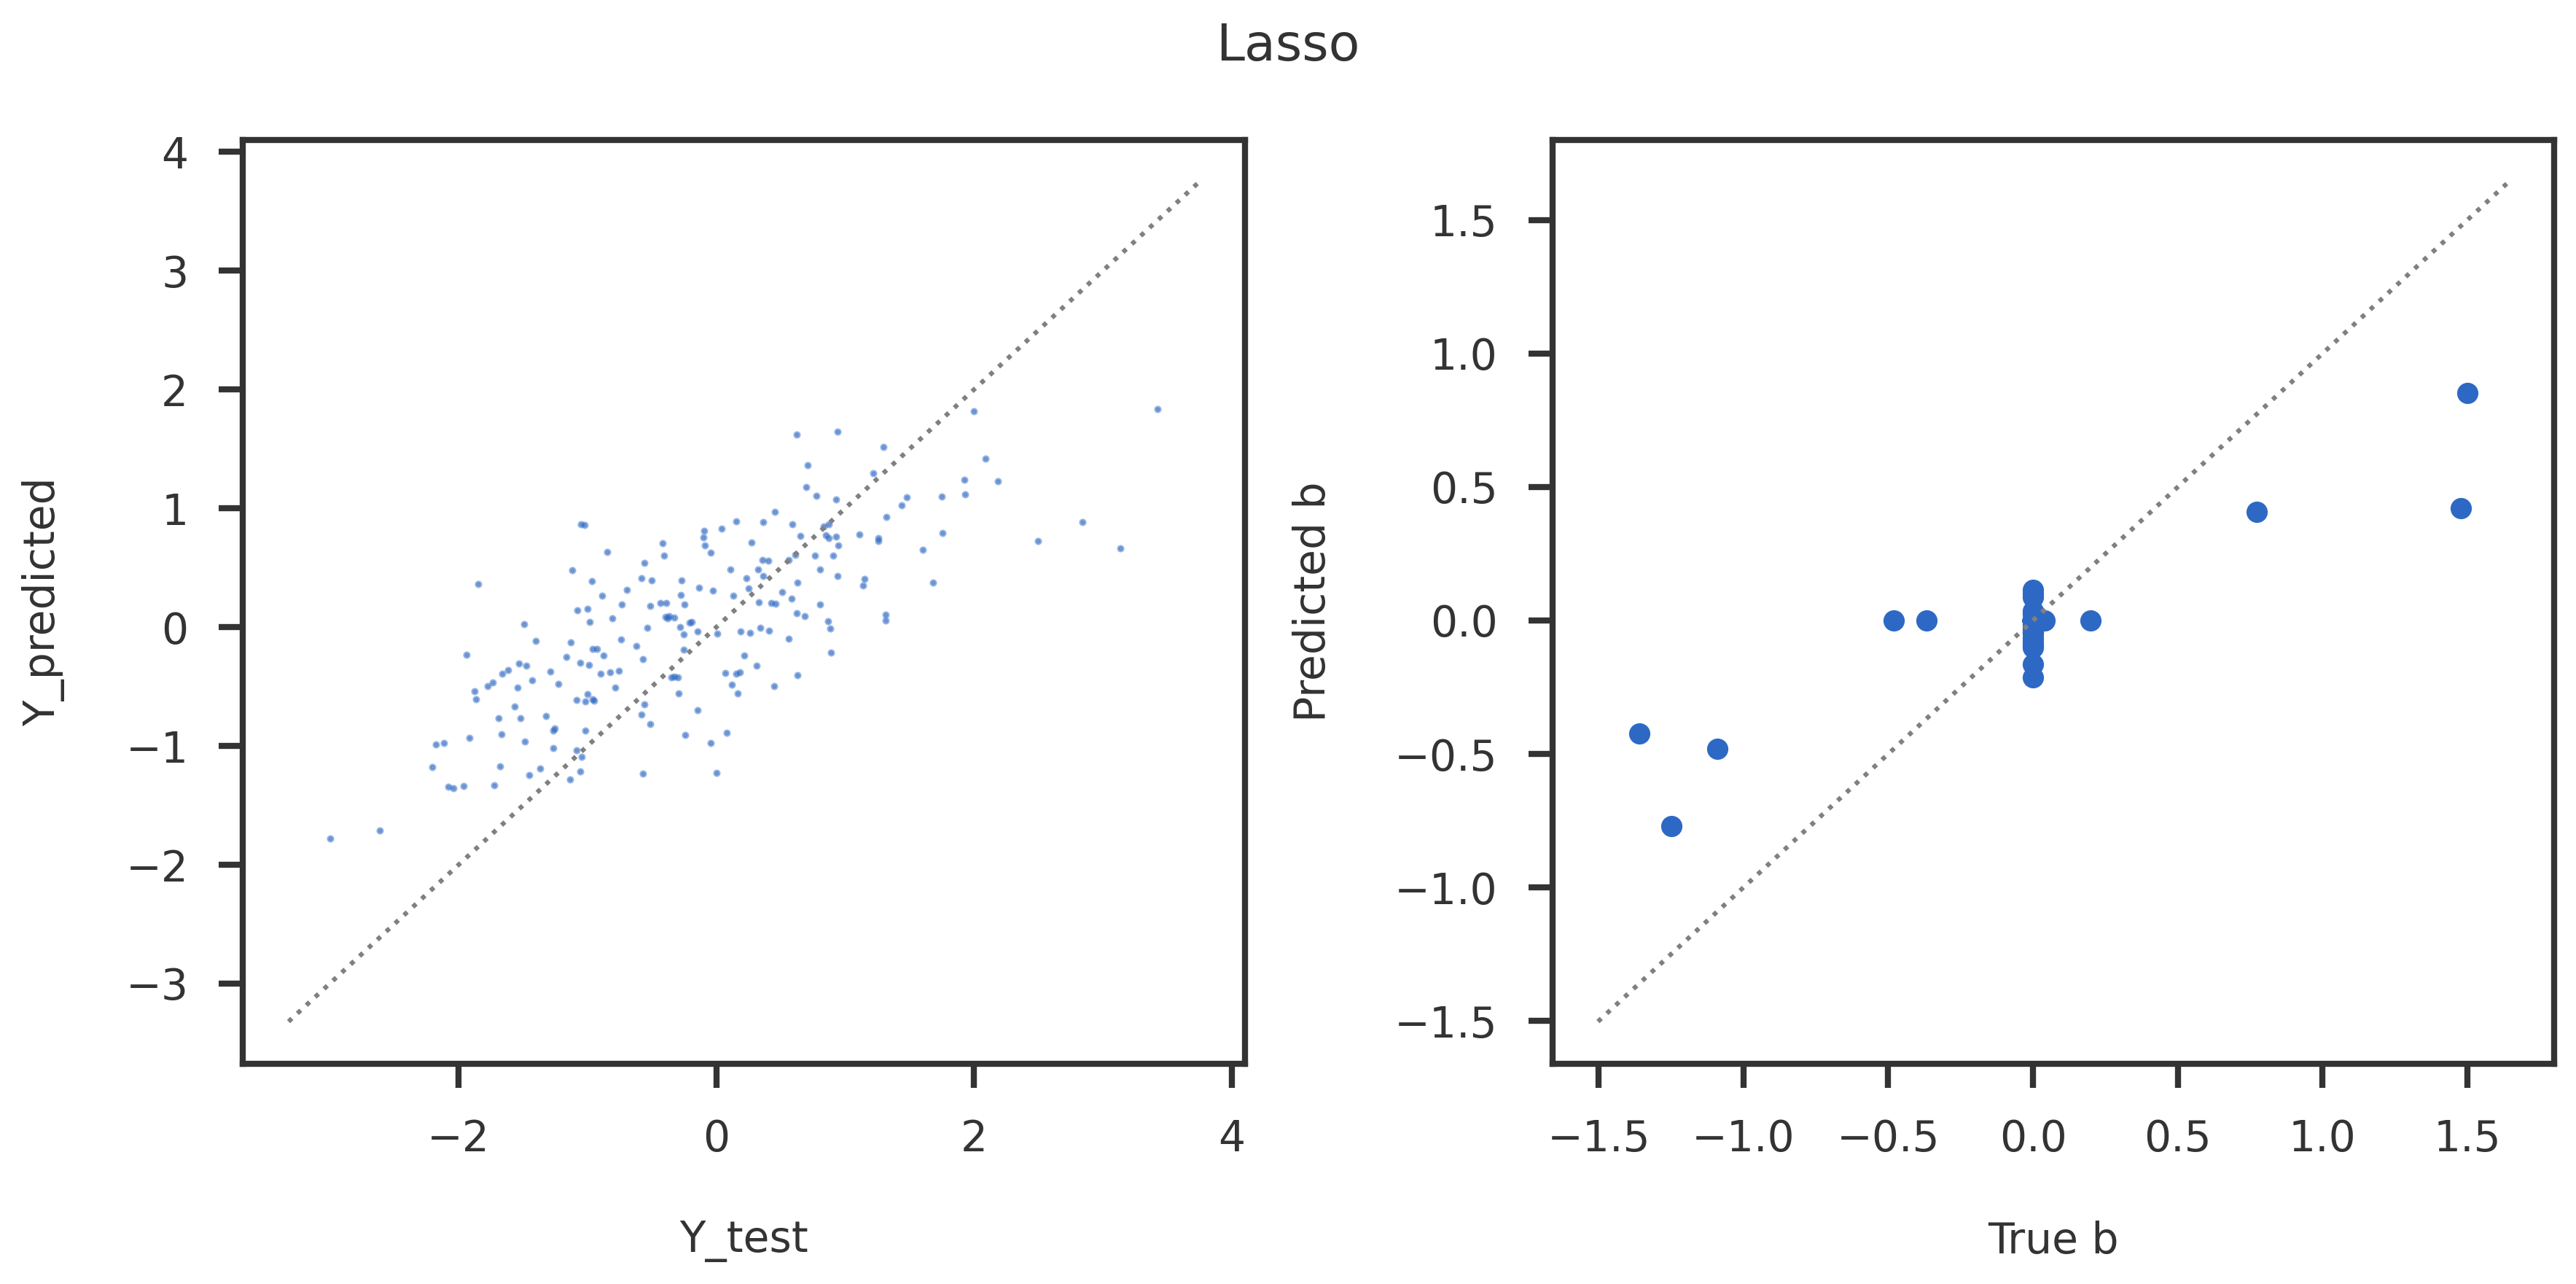

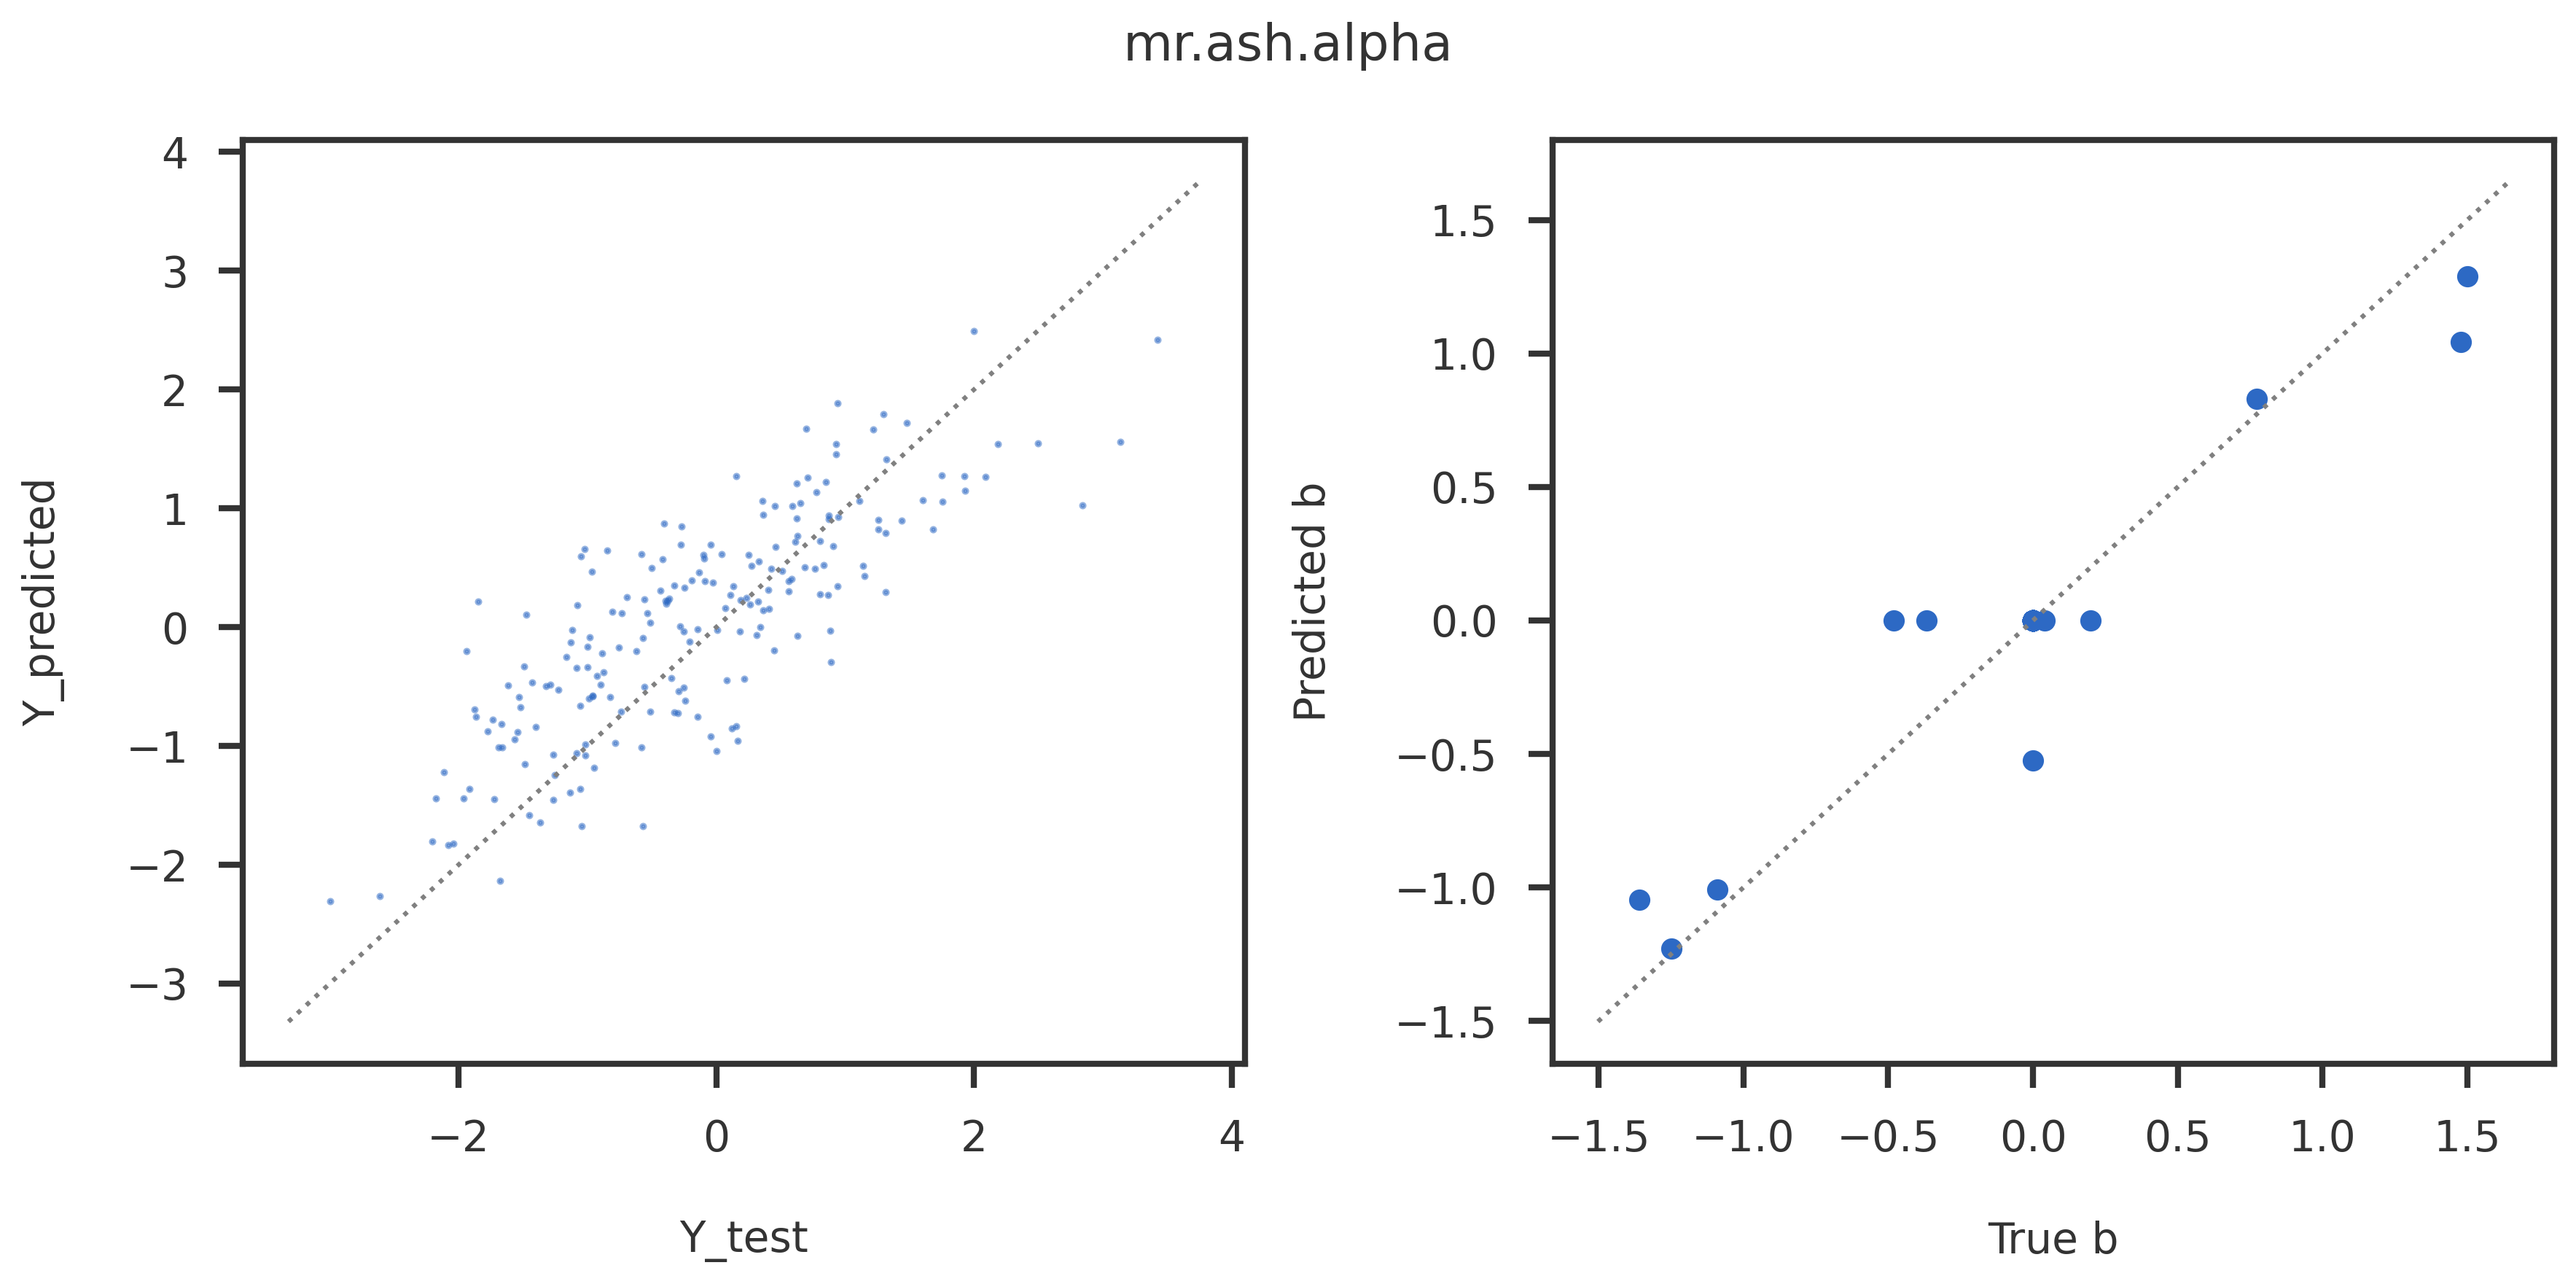

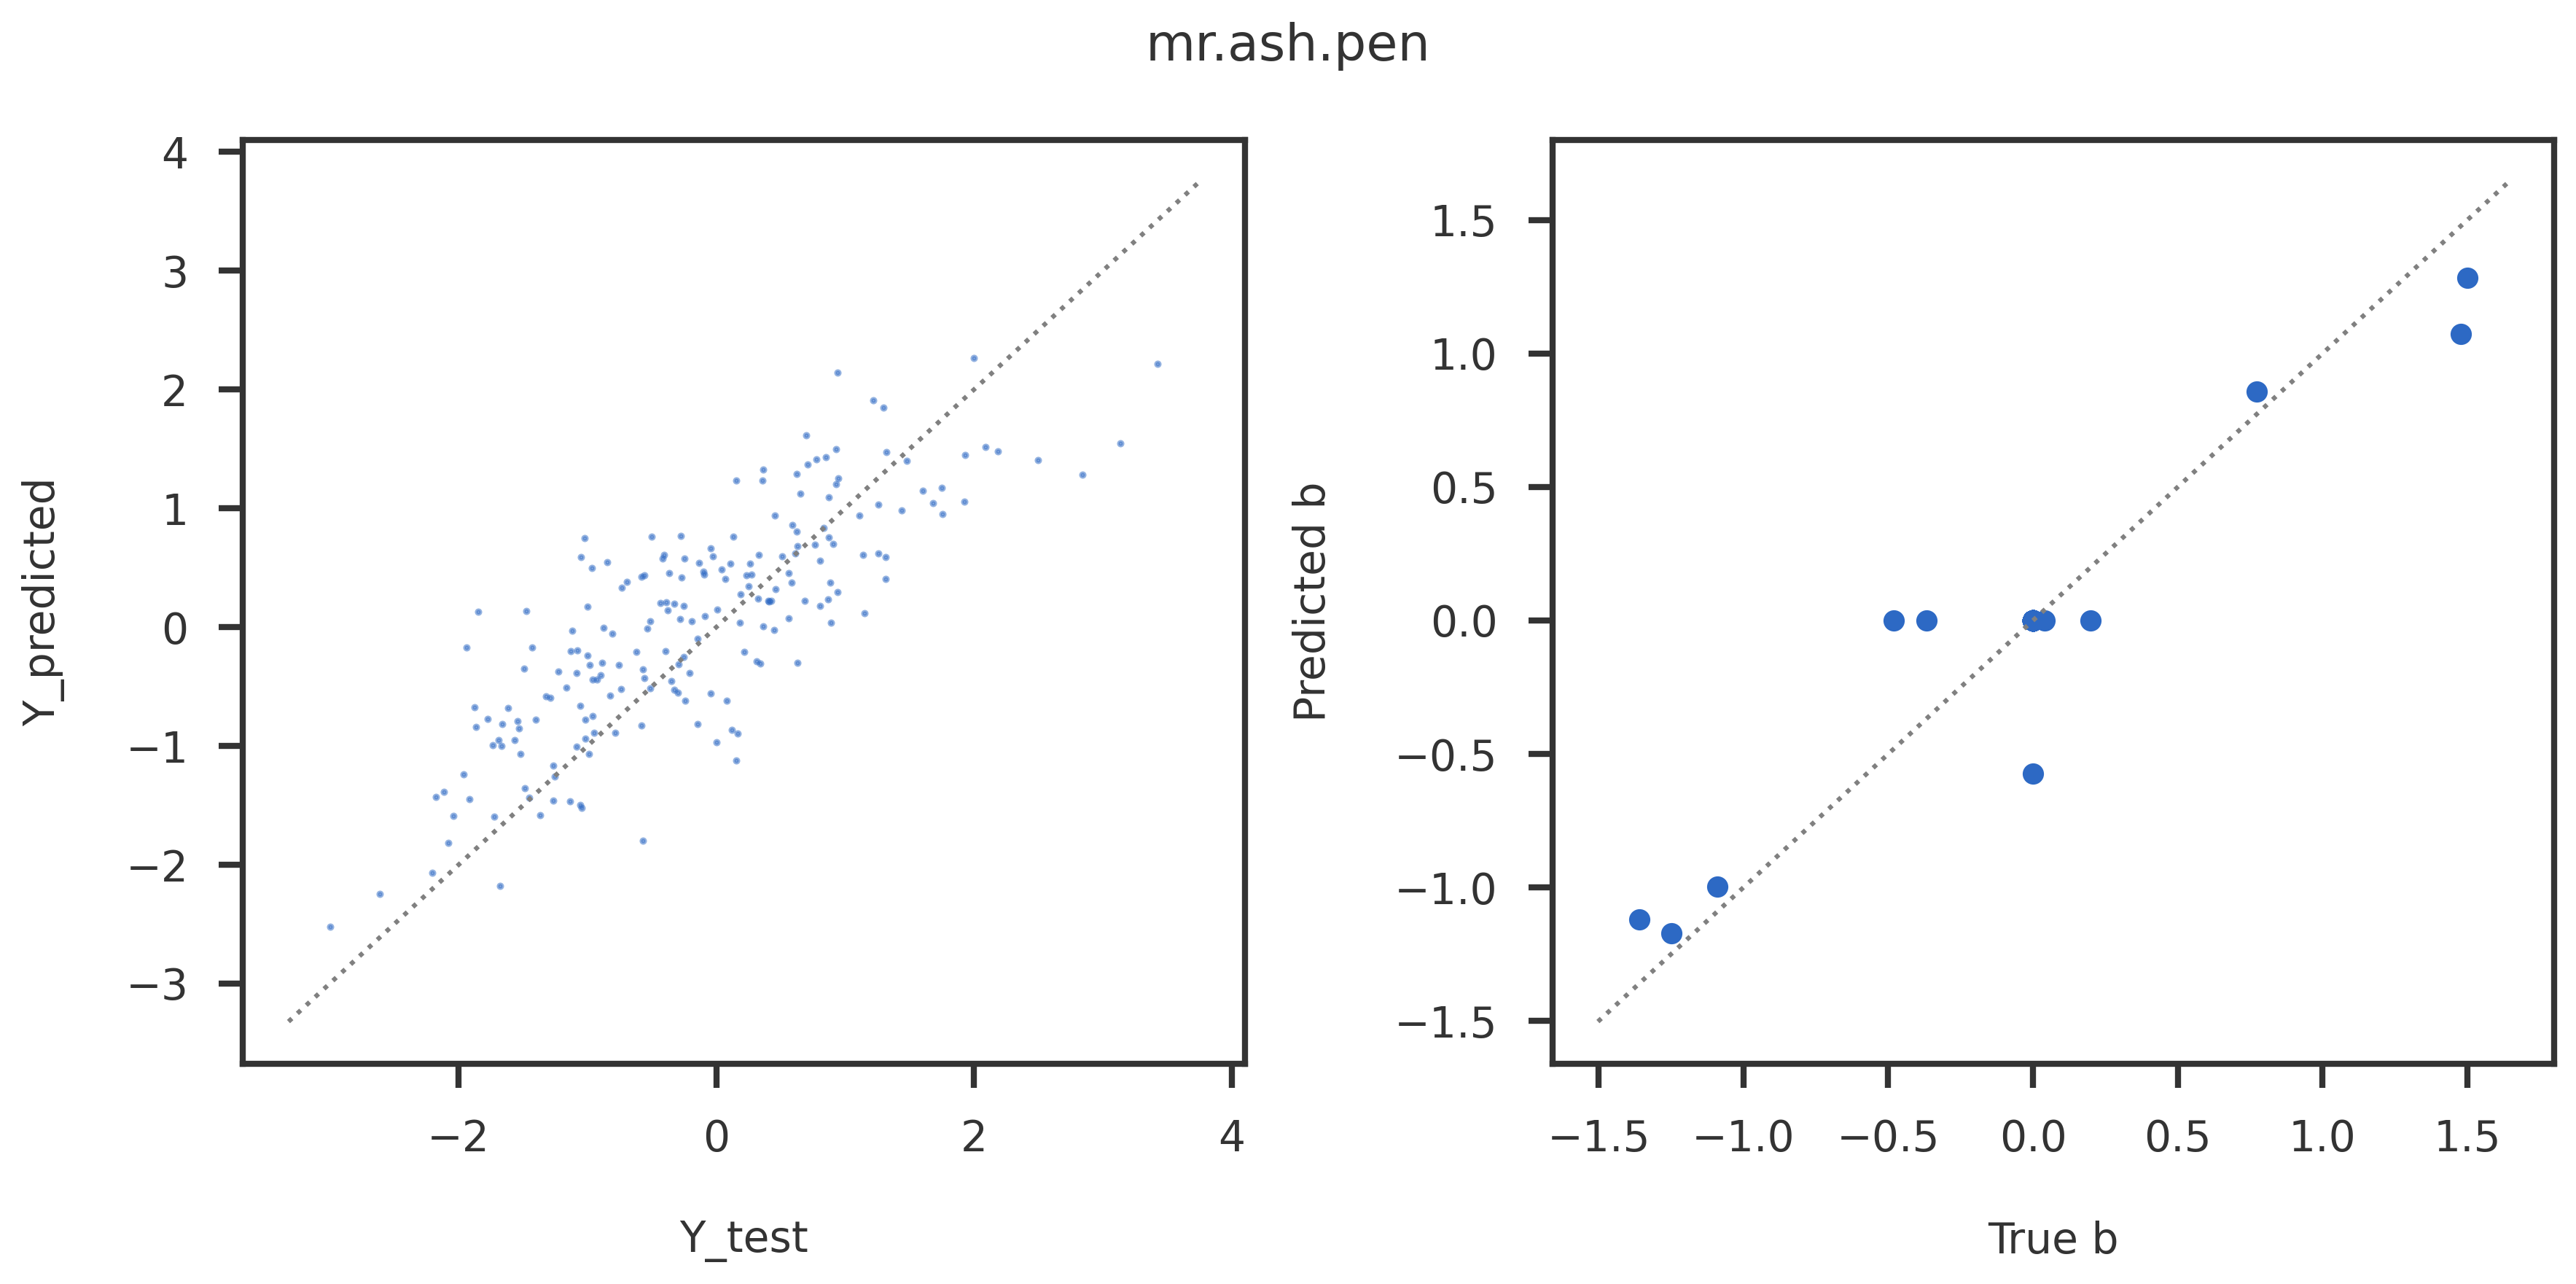

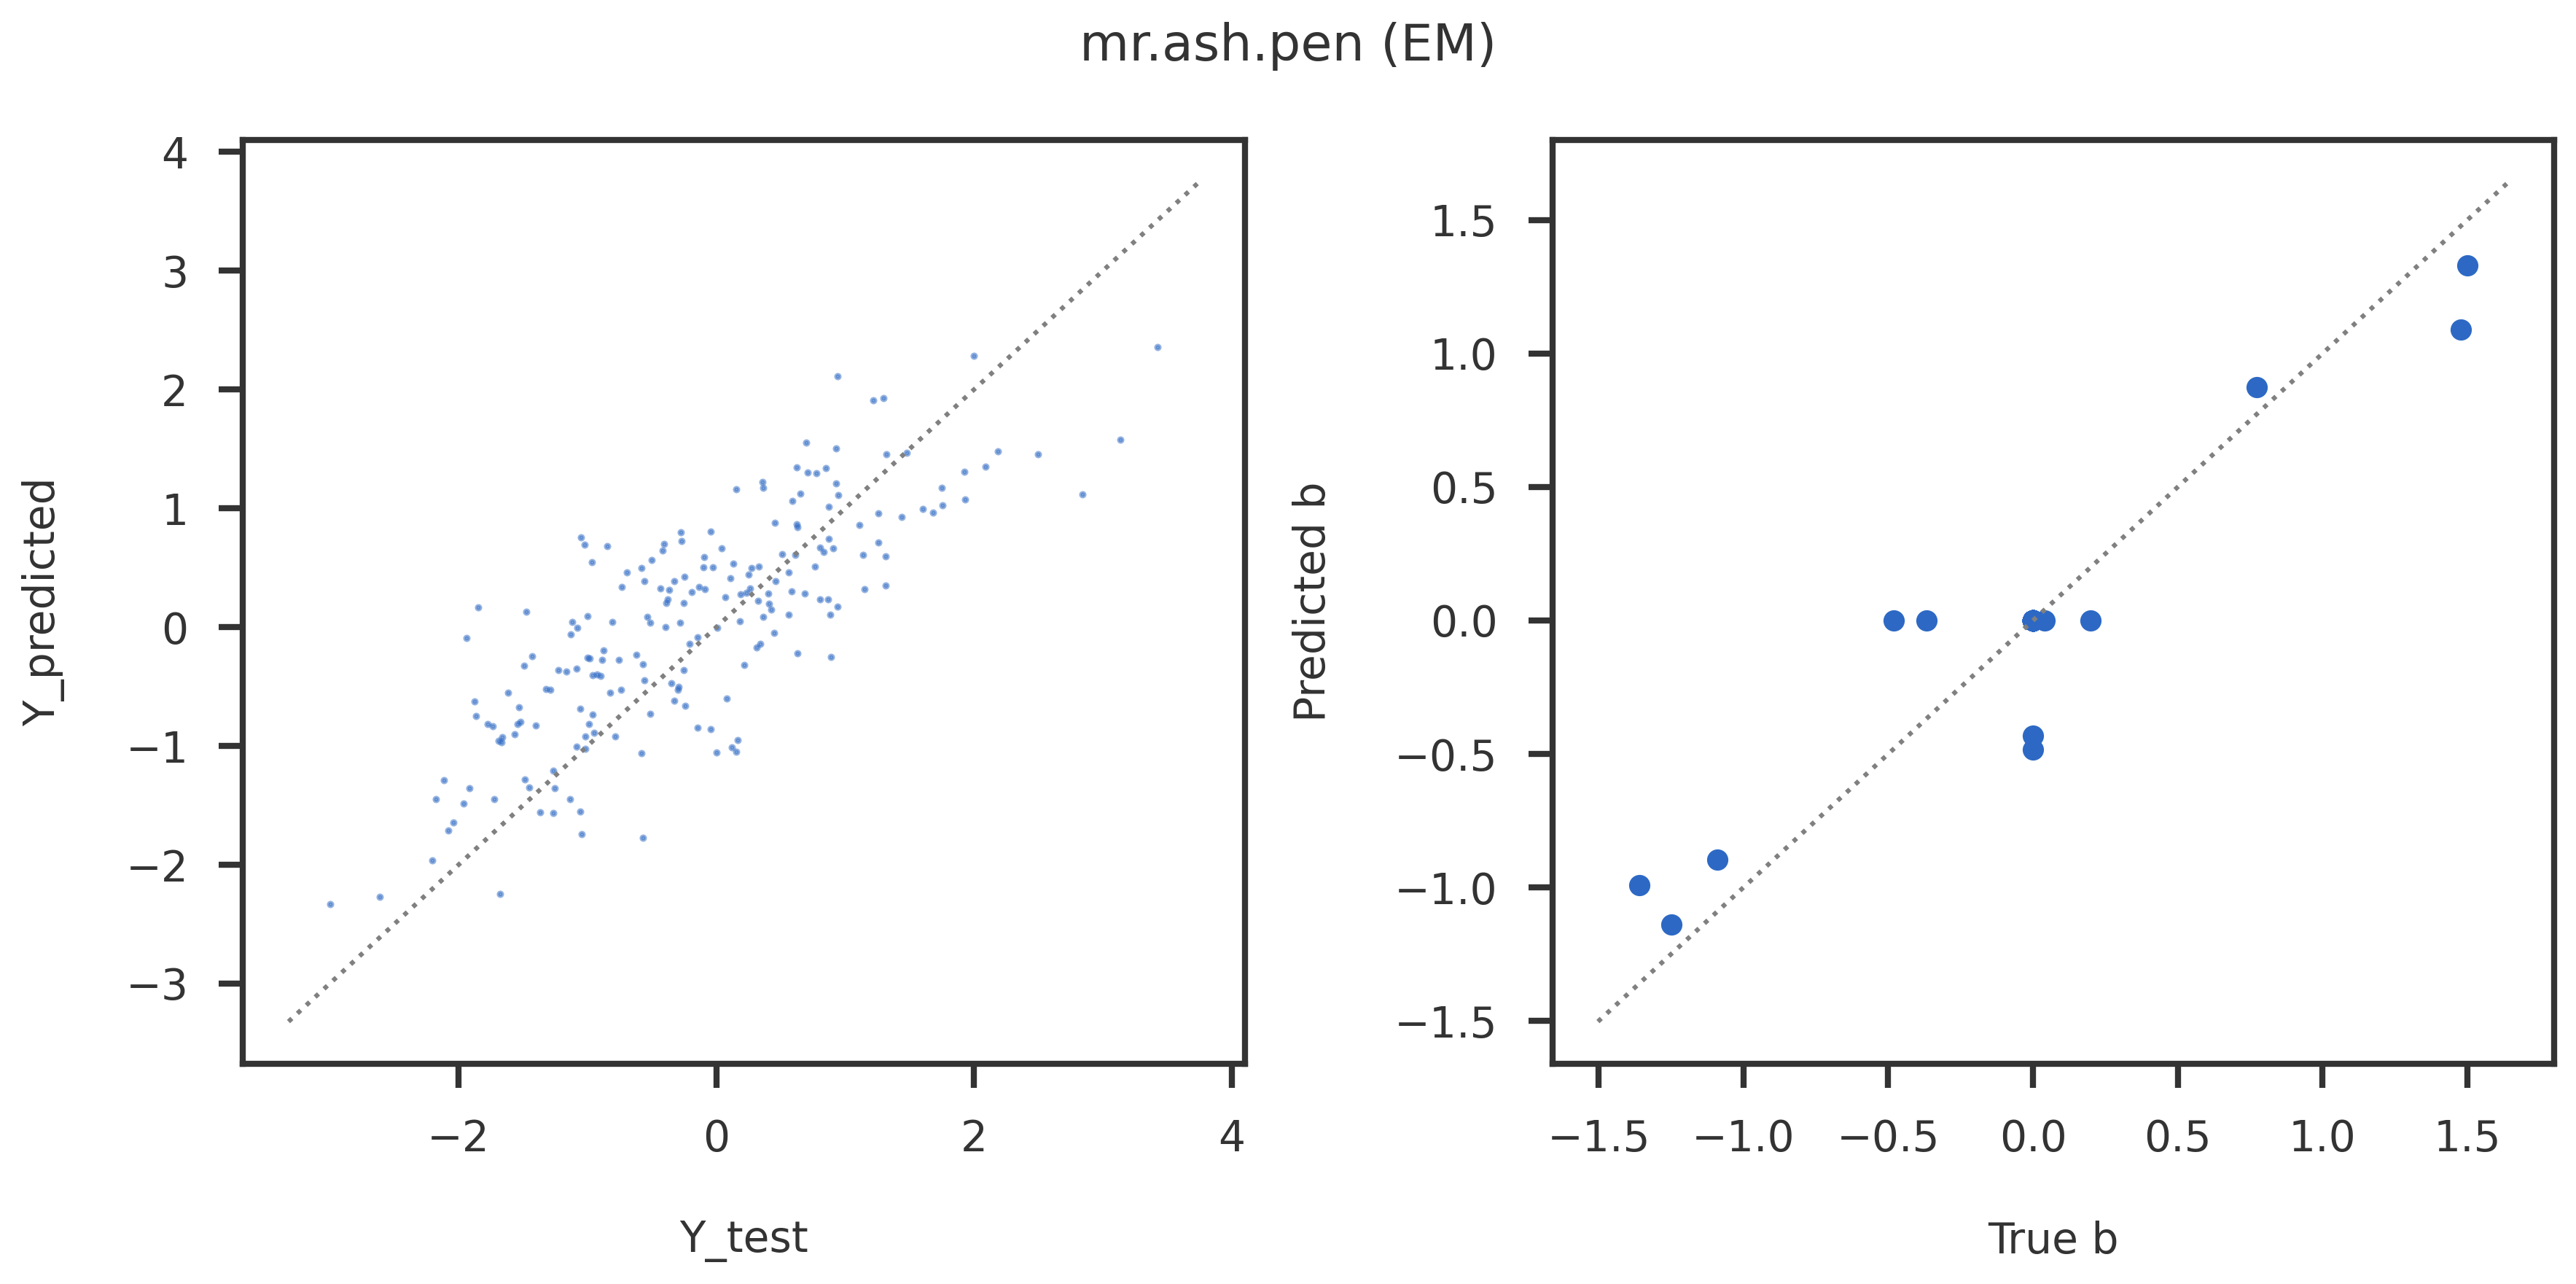

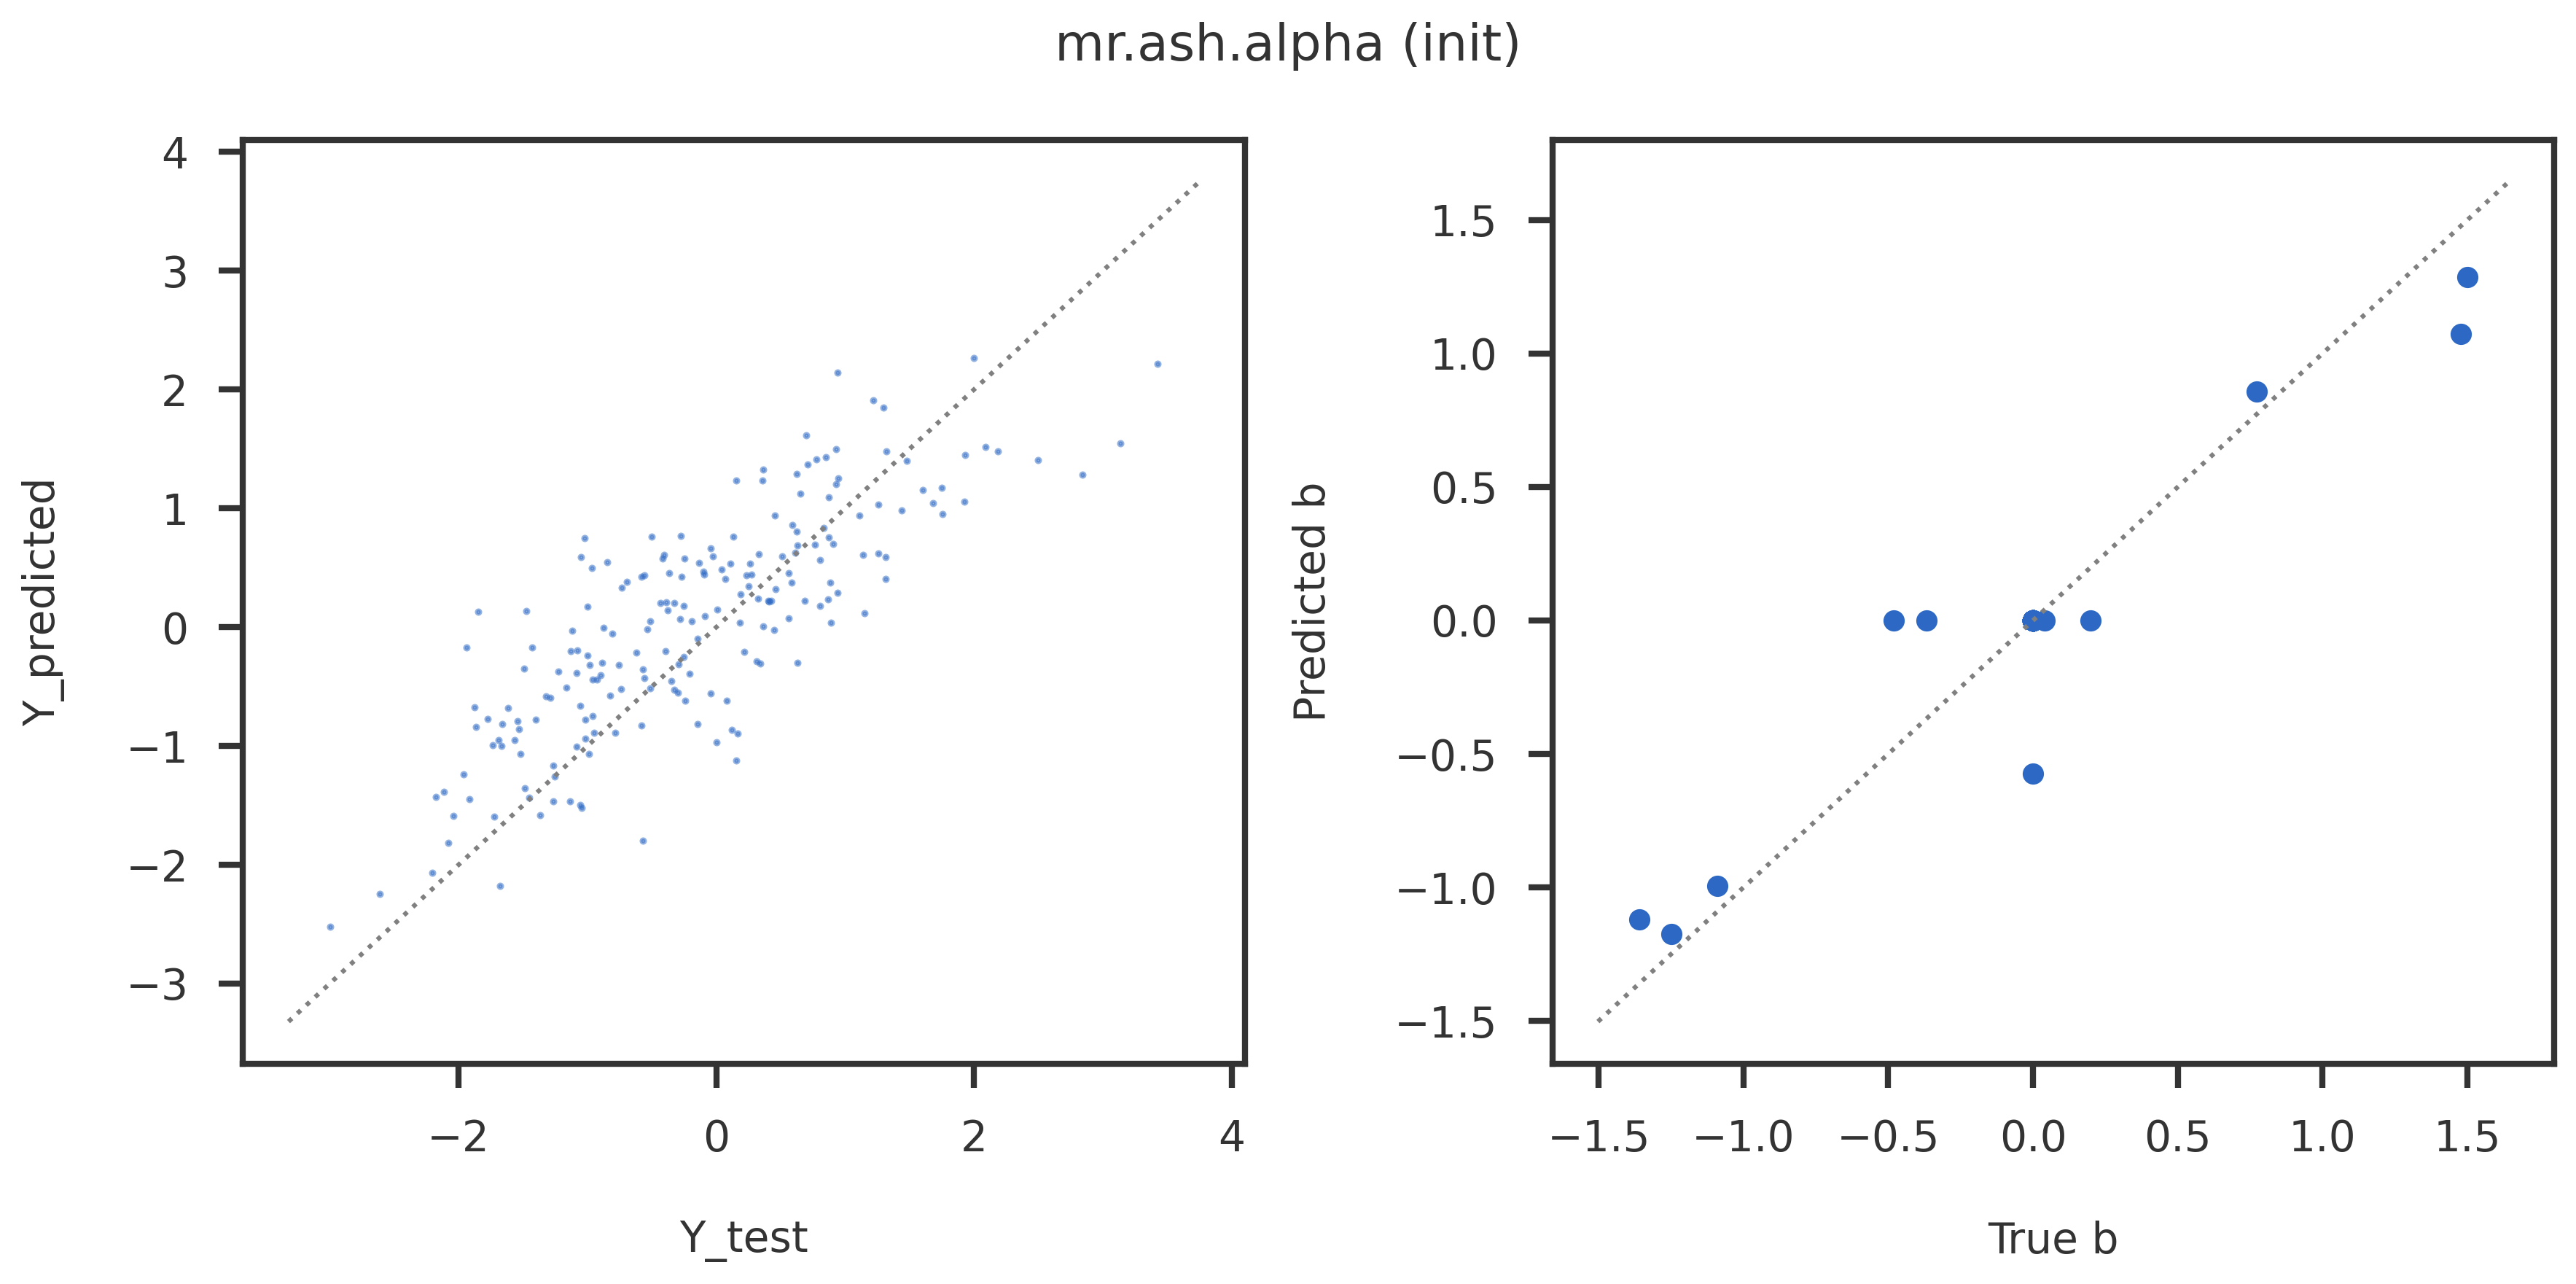

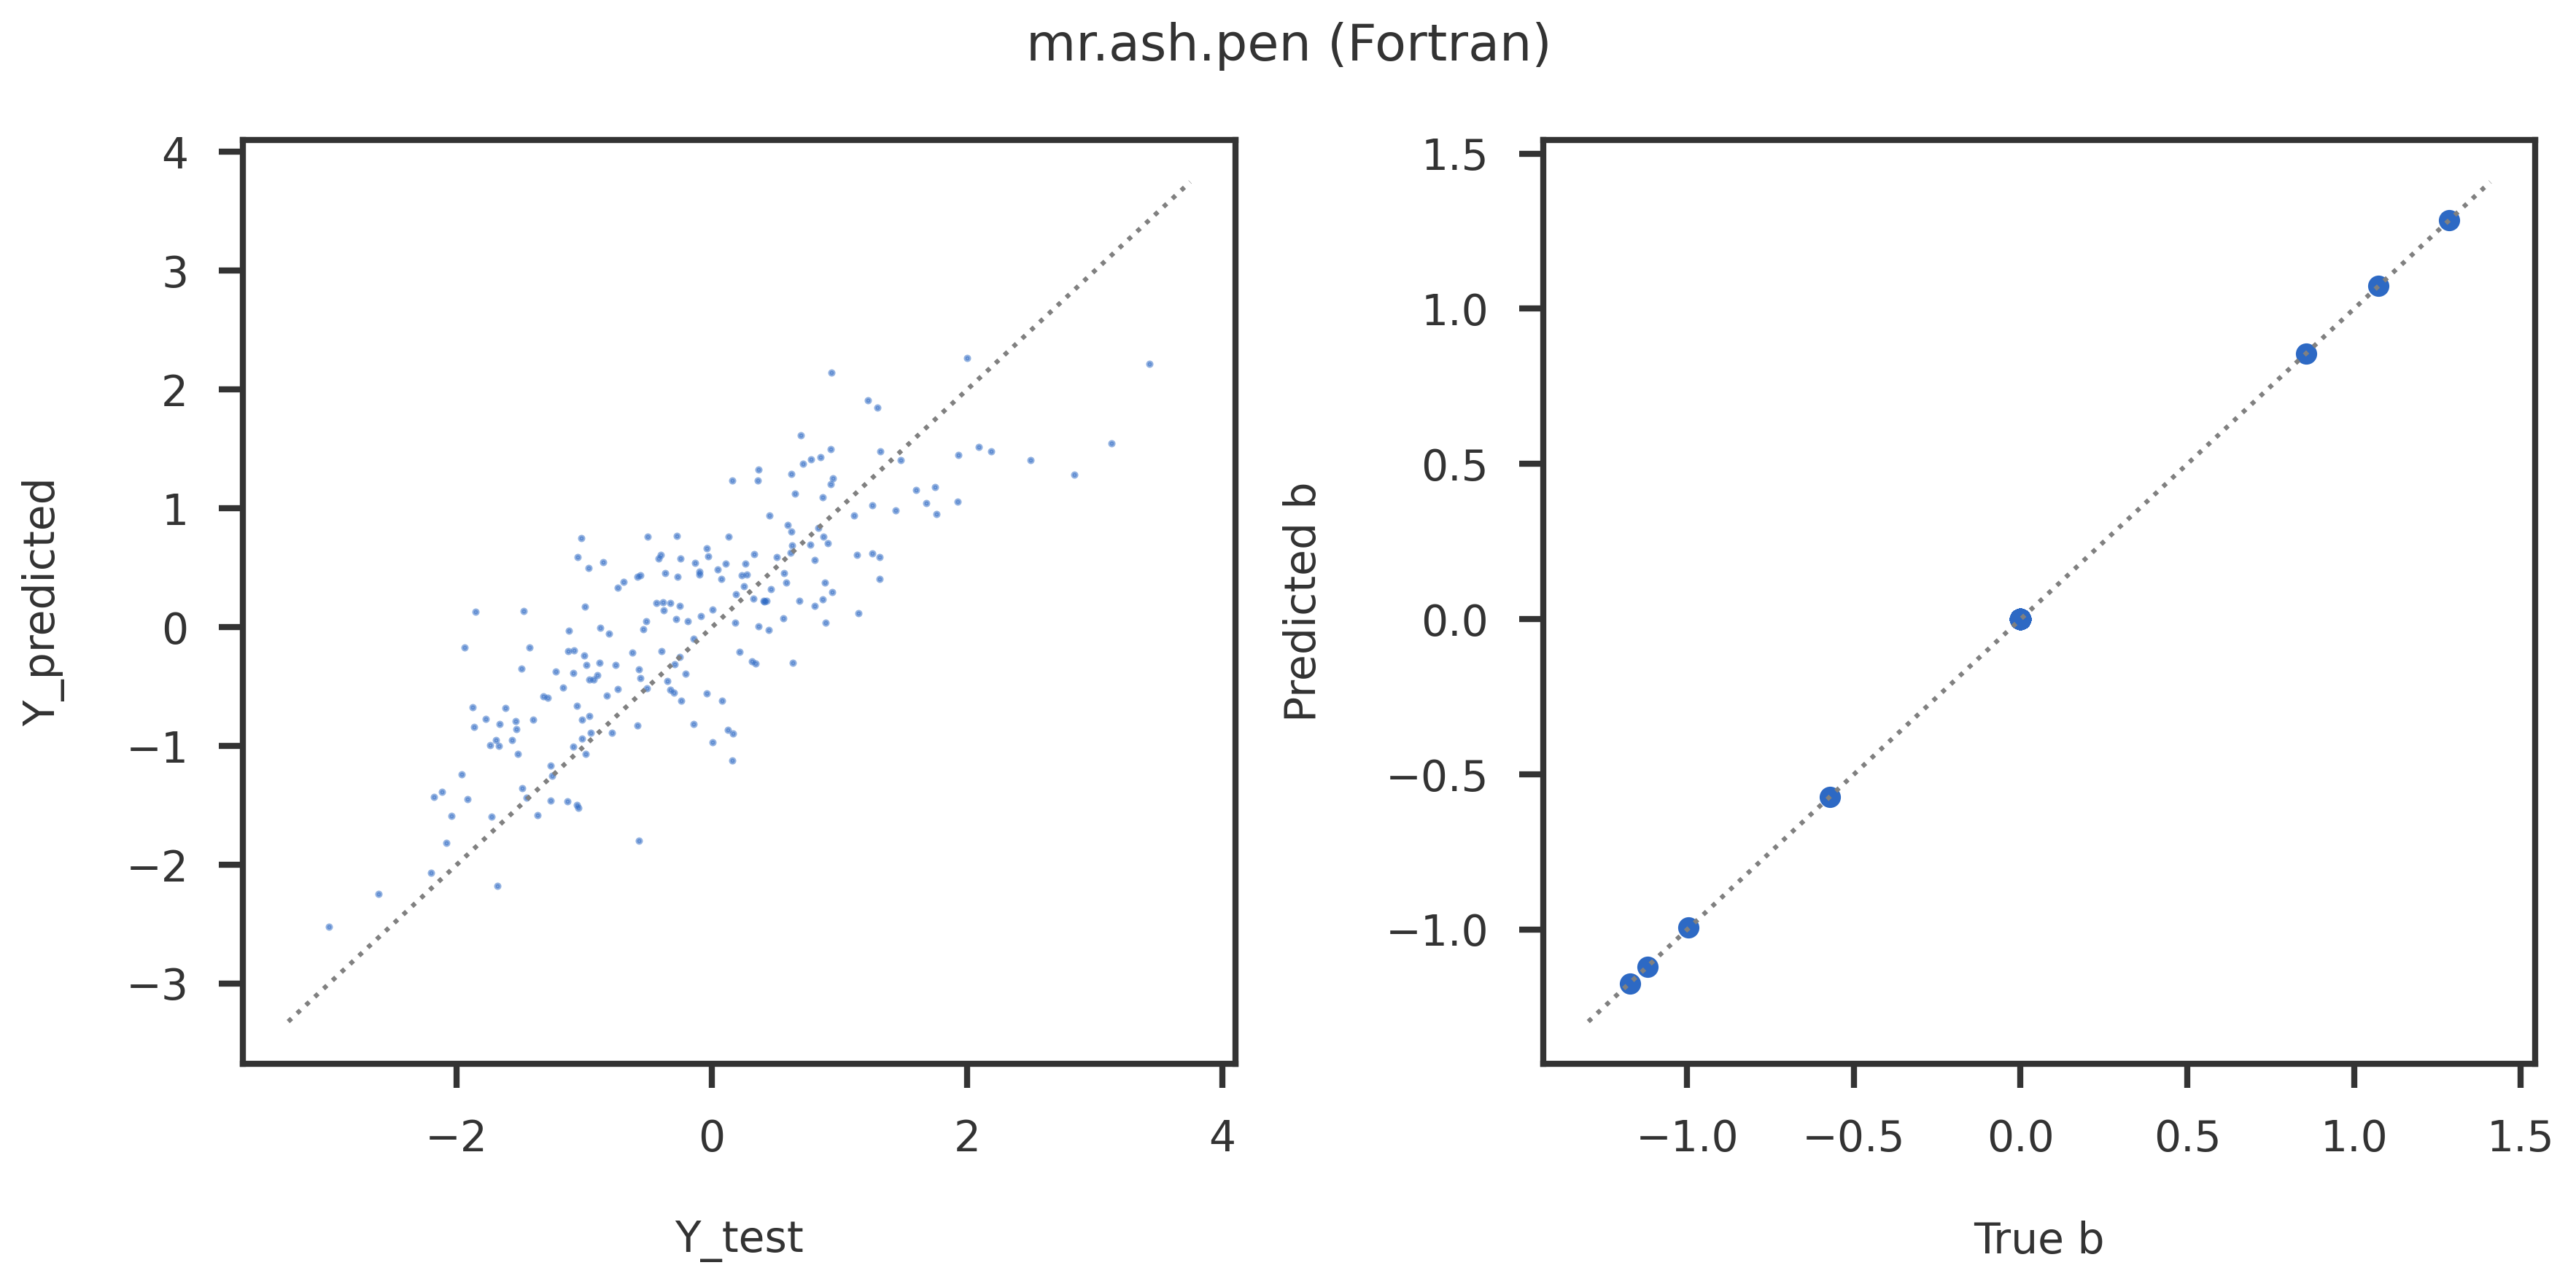

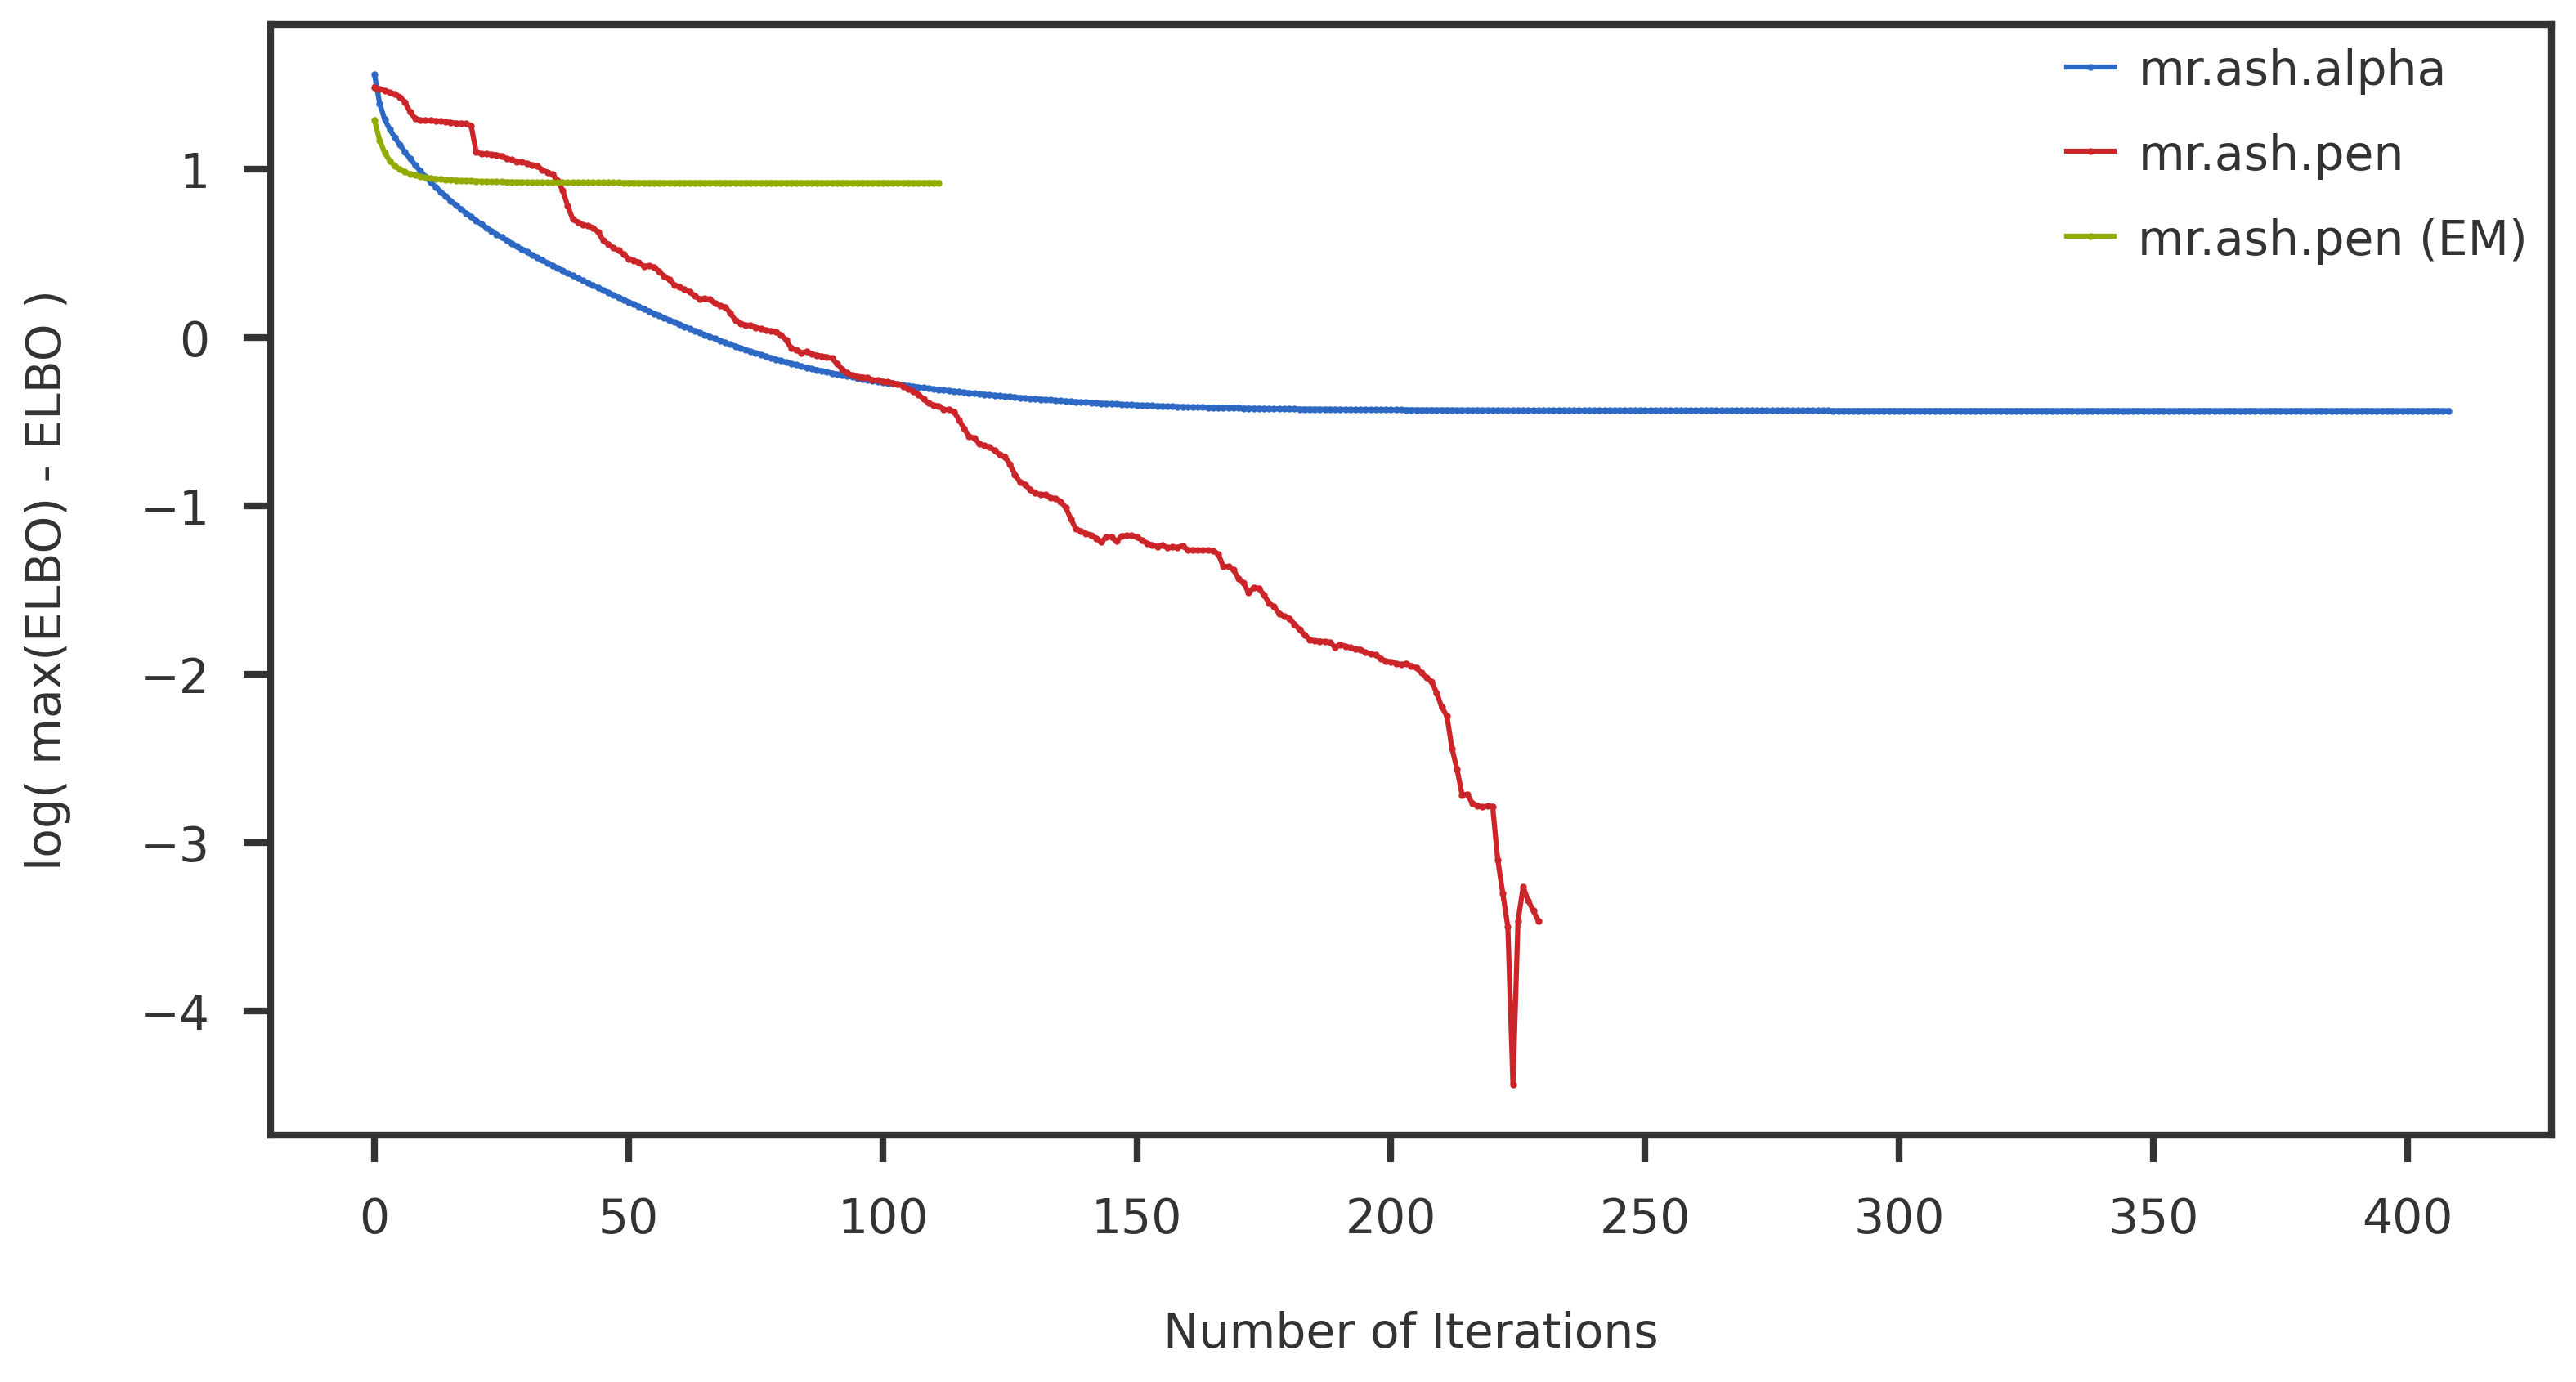

In [10]:
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     lasso_b, intercept = lasso_a0, title = 'Lasso')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue,
                     mrash_r.coef, intercept = mrash_r.intercept, title = 'mr.ash.alpha')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_lbfgs.coef, intercept = plr_lbfgs.intercept, title = 'mr.ash.pen')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_eb.coef, intercept = plr_eb.intercept, title = 'mr.ash.pen (EM)')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     mrash_r_init.coef, intercept = mrash_r_init.intercept, title = 'mr.ash.alpha (init)')

plot_linear_mrashpen(X, y, Xtest, ytest, plr_lbfgs.coef, strue, 
                     plr_lbfgs_f.coef, intercept = plr_lbfgs_f.intercept, title = 'mr.ash.pen (Fortran)')

kinit   = [0, 0, 0]
objs    = [mrash_r.obj_path, plr_lbfgs.elbo_path, plr_eb.outer_elbo_path]
methods = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (EM)"]
# kinit   = [0, 0, 0]
# objs    = [mrash_r.obj_path, plr_lbfgs.elbo_path]
# methods = ["mr.ash.alpha", "mr.ash.pen"]
# kinit   = [0, 0]
# objs    = [plr_lbfgs.elbo_path, plr_eb.outer_elbo_path]
# methods = ["mr.ash.pen", "mr.ash.pen (EM)"]
plot_convergence(objs, methods, kinit)

In [11]:
wk

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

In [12]:
objs     = [mrash_r, plr_lbfgs, plr_eb, mrash_r_init]
methods  = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (EM)", "mr.ash.alpha (init)"]
df       = linreg_summary_df(strue, objs, methods)
# objs     = [mrash_r, plr_lbfgs, mrash_r_init]
# methods  = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.alpha (init)"]
# df       = linreg_summary_df(strue, objs, methods)
df

,sigma2,ELBO,niter
True,0.351862,-,-
mr.ash.alpha,0.422994,261.840476,408
mr.ash.pen,0.411464,267.168101,219
mr.ash.pen (EM),0.412213,267.159325,210
mr.ash.alpha (init),0.411445,267.158148,53


In [13]:
elbo_py.scalemix(X, y, sk, plr_lbfgs.coef, plr_lbfgs.prior, plr_lbfgs.residual_var)

269.8172692502512

In [14]:
elbo_py.scalemix(X, y, sk, mrash_r.coef, mrash_r.prior, mrash_r.residual_var)

264.4896345200844

In [15]:
lasso_a0_2, lasso_b_2, _ = R_lasso.fit(X, y)
s2init_2 = np.var(y - np.dot(X, lasso_b_2) - lasso_a0_2)

lasso_a0_2, lasso_b_2, _ = R_lasso.fit(X, y)
s2init_2 = np.var(y - np.dot(X, lasso_b_2) - lasso_a0_2)

In [16]:
lasso_b[np.abs(lasso_b) > 0.01]

array([-0.17406226, -0.05279857, -0.01455508,  0.10989022,  0.44348001,
       -0.43090039, -0.09800836, -0.03463724, -0.77897753, -0.07238876,
       -0.49690725, -0.02466641, -0.08098378, -0.11047429, -0.05957943,
       -0.05112906,  0.04387054, -0.05882383,  0.11570547, -0.01418067,
        0.86930306,  0.43194023, -0.21276732, -0.11025782,  0.04352053,
       -0.03070659,  0.05822075,  0.13631074])

In [17]:
lasso_b_2[np.abs(lasso_b) > 0.01]

array([-0.17406226, -0.05279857, -0.01455508,  0.10989022,  0.44348001,
       -0.43090039, -0.09800836, -0.03463724, -0.77897753, -0.07238876,
       -0.49690725, -0.02466641, -0.08098378, -0.11047429, -0.05957943,
       -0.05112906,  0.04387054, -0.05882383,  0.11570547, -0.01418067,
        0.86930306,  0.43194023, -0.21276732, -0.11025782,  0.04352053,
       -0.03070659,  0.05822075,  0.13631074])

In [18]:
s2init

0.4066349738762403

In [19]:
s2init_2

0.4066349738762403

In [20]:
%%timeit -n 1 -r 5
plr_lbfgs = PLR(method = 'L-BFGS-B', is_prior_scaled = True,
                debug = False, display_progress = False, calculate_elbo = False, 
                maxiter = 2000, tol = 1e-8, function_call = 'python', lbfgsb_call = 'python')
plr_lbfgs.fit(X, y, sk, binit = lasso_b, winit = winit, s2init = s2init)

mr.ash.pen terminated at iteration 219.
mr.ash.pen terminated at iteration 219.
mr.ash.pen terminated at iteration 219.
mr.ash.pen terminated at iteration 219.
mr.ash.pen terminated at iteration 219.
2.12 s ± 13 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [21]:
%%timeit -n 1 -r 5
plr_lbfgs = PLR(method = 'L-BFGS-B', is_prior_scaled = True,
                debug = False, display_progress = False, calculate_elbo = False, 
                maxiter = 2000, tol = 1e-8, lbfgsb_call = 'fortran')
plr_lbfgs.fit(X, y, sk, binit = lasso_b, winit = winit, s2init = s2init)

mr.ash.pen terminated at iteration 230.
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
mr.ash.pen terminated at iteration 230.
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
mr.ash.pen terminated at iteration 230.
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
mr.ash.pen terminated at iteration 230.
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
mr.ash.pen terminated at iteration 230.
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
958 ms ± 4.27 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [22]:
%%timeit -n 1 -r 5
mrash_r = MrASHR(option = "r2py", debug = False)
mrash_r.fit(X, y, sk, binit = lasso_b, winit = winit, s2init = s2init)

Mr.ASH terminated at iteration 408.
Mr.ASH terminated at iteration 408.
Mr.ASH terminated at iteration 408.
Mr.ASH terminated at iteration 408.
Mr.ASH terminated at iteration 408.
915 ms ± 23.2 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)
